In [1]:
import math, pathlib, json, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

width    8:  epochs 1484,  test MSE 9.99e-04,  RTV 19.0
width   16:  epochs  735,  test MSE 9.95e-04,  RTV 49.2
width   32:  epochs  699,  test MSE 9.98e-04,  RTV 79.5
width   64:  epochs  774,  test MSE 9.98e-04,  RTV 147.3
width  128:  epochs 1342,  test MSE 1.00e-03,  RTV 306.7
width  256:  epochs  949,  test MSE 1.00e-03,  RTV 622.3
width  512:  epochs  619,  test MSE 1.00e-03,  RTV 1268.5


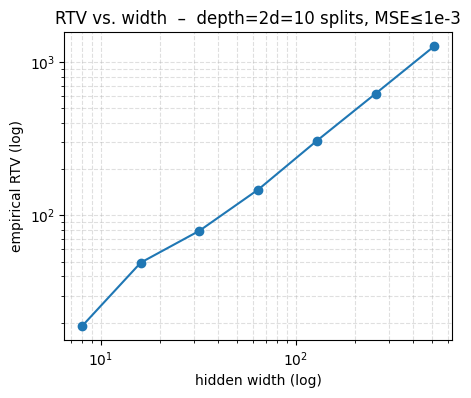

In [2]:
# ===== 1. Imports =====
import numpy as np, torch, torch.nn as nn, torch.optim as optim, matplotlib.pyplot as plt

# ===== 2. Hard 0/1 box with 2d splits =====
def make_box_target(X, lows, highs):
    """
    X : (n,d) float32 array
    lows, highs : length-d arrays with lows < highs
    returns 0/1 labels for the axis-aligned box  Π_i [l_i, h_i].
    """
    inside = np.all((X >= lows) & (X <= highs), axis=1)
    return inside.astype(np.float32)

# --- parameters for the box ---
d       = 5                             # ambient dimension
lows    = np.zeros(d, dtype=np.float32) # [0, 1]^d box by default
highs   = np.ones (d, dtype=np.float32)

# ===== 3. Dense train / test sets =====
N_TRAIN = 100_000
N_TEST  =  20_000
X_train = np.random.rand(N_TRAIN, d).astype(np.float32)
X_test  = np.random.rand(N_TEST,  d).astype(np.float32)
y_train = make_box_target(X_train, lows, highs)
y_test  = make_box_target(X_test,  lows, highs)
X_train, X_test = map(torch.tensor, (X_train, X_test))
y_train = torch.tensor(y_train).unsqueeze(1)
y_test  = torch.tensor(y_test).unsqueeze(1)

# ===== 4. Model & RTV proxy =====
# ===== Correct finite-width RTV (C(theta)) definition =====
class OneHidden(nn.Module):
    """
    Single-hidden-layer ReLU network
    g(x) = Σ a_i [w_i^T x + b_i]_+   (bias terms are ignored in the cost)
    RTV  = 0.5 * Σ (‖w_i‖_2^2 + a_i^2)
    """
    def __init__(self, input_dim, width):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, width)    # w_i and b_i
        self.fc2 = nn.Linear(width, 1, bias=False)  # a_i
        nn.init.normal_(self.fc1.weight, 0, 1)
        nn.init.normal_(self.fc2.weight, 0, 0.1)

    def forward(self, x):
        return self.fc2(torch.relu(self.fc1(x)))

    def rtv(self):
        """
        C(theta) = 0.5 * [ Σ_i ‖w_i‖_2^2  +  Σ_i a_i^2 ]
        (bias terms excluded as in the definition you provided)
        """
        W = self.fc1.weight             # shape (width, d)
        a = self.fc2.weight.squeeze()   # shape (width,)
        return 0.5 * (W.pow(2).sum().item() + a.pow(2).sum().item())

# ===== 5. Width sweep =====
WIDTHS  = [8, 16, 32, 64, 128, 256, 512]
THR_MSE = 1e-3
EPOCHS  = 3000
RTVs, MSEs = [], []

for W in WIDTHS:
    model = OneHidden(d, W)
    opt   = optim.Adam(model.parameters(), lr=1e-3)
    best_mse, best_rtv = 1.0, None
    for epoch in range(EPOCHS):
        model.train(); opt.zero_grad()
        loss = nn.functional.mse_loss(model(X_train), y_train)
        loss.backward(); opt.step()

        with torch.no_grad():
            mse = nn.functional.mse_loss(model(X_test), y_test).item()
            if mse < best_mse: best_mse, best_rtv = mse, model.rtv()
            if mse <= THR_MSE: break
    RTVs.append(best_rtv); MSEs.append(best_mse)
    print(f"width {W:4d}:  epochs {epoch+1:4d},  test MSE {best_mse:.2e},  RTV {best_rtv:.1f}")

# ===== 6. RTV vs. width plot =====
plt.figure(figsize=(5,4))
plt.loglog(WIDTHS, RTVs, marker='o')
plt.xlabel("hidden width (log)")
plt.ylabel("empirical RTV (log)")
plt.title(f"RTV vs. width  –  depth=2d={2*d} splits, MSE≤1e-3")
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.show()
